In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
import xarray as xr
from tensorflow import keras


from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf

import model_eval

import matplotlib_functions as mympf

import oco3_utils

setMatplotlibParam()
plt.viridis()

2024-10-30 13:49:24.507610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 13:49:24.507643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 13:49:24.507670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 13:49:24.514750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 1920x1440 with 0 Axes>

In [3]:
dir_res = "/libre/dumontj/coco2/weights/new"
dir_ds = "/libre/dumontj/coco2/dl-input"

## Infos on OCO3

In [4]:
name_eval_nc = "oco3/dataset.nc"
ds = xr.open_dataset(os.path.join(dir_ds, name_eval_nc))
ds

<xarray.Dataset>
Dimensions:       (idx_img: 39, y: 32, x: 32, hour_prec: 3)
Coordinates:
  * idx_img       (idx_img) int32 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38
  * y             (y) int32 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * x             (x) int32 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
Dimensions without coordinates: hour_prec
Data variables:
    point_source  (idx_img) object ...
    time          (idx_img) datetime64[ns] ...
    biased_xco2   (idx_img, y, x) float32 ...
    xco2          (idx_img, y, x) float32 ...
    xco2_noisy    (idx_img, y, x) float32 ...
    lats          (idx_img, y, x) float32 ...
    lons          (idx_img, y, x) float32 ...
    emiss         (idx_img, hour_prec) float32 ...
    all_v         (idx_img, y, x, hour_prec) float64 ...
    all_u         (idx_img, y, x, hour_prec) float64 ...
    v             (idx_img, y, x) float64 ...
    u             (idx_img, y, x) float64 ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_img:        39

## Model

In [5]:
name_model = "inv_oco3_32_sweep/3"
path_oco3_dataset = os.path.join(dir_ds, "oco3/dataset.nc")

In [6]:
cfg = OmegaConf.load(os.path.join(dir_res, name_model, "config.yaml"))

In [7]:
cfg

{'data': {'init': {'_target_': 'Data.Data_train', 'path_train_ds': '${data.path.directory}/${data.path.train.name}/${data.path.train.nc}', 'path_valid_ds': '${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}', 'path_valid_2_ds': '${data.path.directory}/${data.path.valid_2.name}/${data.path.valid_2.nc}', 'path_extra_valid_ds': '${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}'}, 'input': {'dir_seg_models': '/cerea_raid/users/dumontj/dev/coco2/dl/res/models', 'chan_0': 'xco2', 'chan_1': 'u_wind', 'chan_2': 'v_wind', 'chan_3': 'None', 'chan_4': 'None', 'clouds_threshold': 0.5, 'dir_clouds_array': '/libre/dumontj/coco2/dl-input/clouds', 'timedate': True}, 'output': {'N_emissions': 1}, 'path': {'directory': '/libre/dumontj/coco2/dl-input', 'train': {'name': '2km_forOco3_32', 'nc': 'dataset.nc'}, 'valid': {'name': '2km_Dolo_32_beta_distribution_mapping', 'nc': 'dataset.nc'}, 'valid_2': {'name': '2km_Dolo_32', 'nc': 'dataset.nc'}, 'extra_valid

In [8]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2024-10-30 13:49:41.458433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14611 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


### Print results

In [9]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_oco3_dataset
)

ic| self.eval.shape: (39, 32, 32, 3)
2024-10-30 13:49:43.438317: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [10]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.median(metrics["mae"]))
print("mape:", np.median(metrics["mape"]))

2024-10-30 13:49:45.385216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-10-30 13:49:45.985834: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


mae: 5.581339
mape: 28.209099


In [11]:
print(np.c_[inv_eval.pred, inv_eval.y])

[[12.28170109 13.60000038]
 [21.14246941 13.60000038]
 [ 9.88344479 13.60000038]
 [ 7.73575926 13.60000038]
 [26.99337769 37.59999847]
 [27.9168148  37.59999847]
 [32.2807045  37.59999847]
 [29.08665085 37.59999847]
 [18.75683212 30.        ]
 [11.52125359 30.        ]
 [22.20327377 30.        ]
 [24.41866112 30.        ]
 [22.01420975 30.        ]
 [26.95474052 30.        ]
 [14.71452999 30.        ]
 [22.32366753 30.        ]
 [13.65660286 12.37349987]
 [ 5.47044802 12.37349987]
 [ 7.28231621 12.37349987]
 [ 5.65614414 14.96500015]
 [11.06975842 14.96500015]
 [ 8.78039932 14.96500015]
 [18.72176933 14.96500015]
 [ 8.66532803 14.96500015]
 [14.95039558 14.96500015]
 [ 4.10734749  5.03700018]
 [ 7.68532658  5.03700018]
 [ 9.52156258  7.19049978]
 [ 7.52413082  7.19049978]
 [21.83016777  7.19049978]
 [12.65175724  7.19049978]
 [19.70424843  7.19049978]
 [29.4023571   7.19049978]
 [10.33056641  7.19049978]
 [10.97157574 13.17650032]
 [19.88405609 13.17650032]
 [ 8.20970726 13.17650032]
 

<Figure size 1920x1440 with 0 Axes>

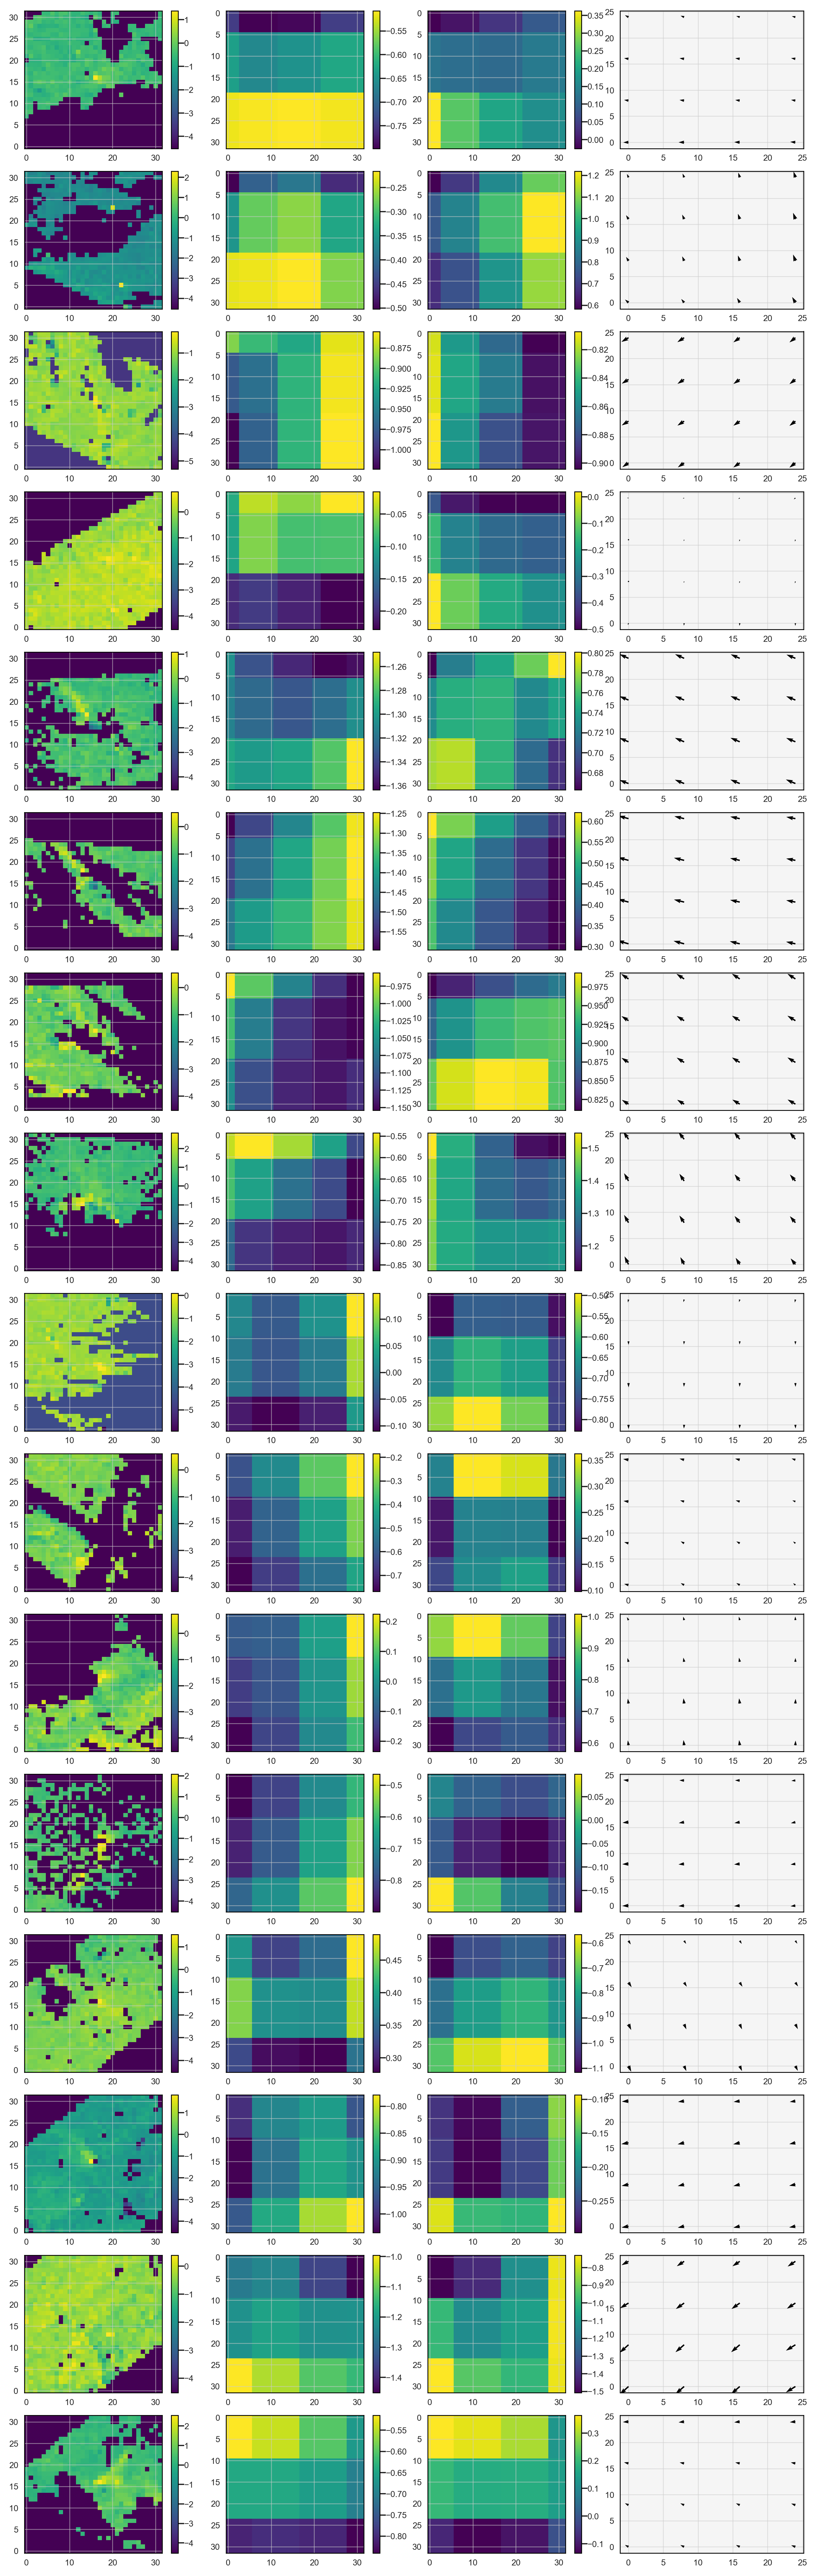

In [12]:
N_cols = 4
N_rows = 16
mympf.setMatplotlibParam()
plt.viridis()
axs = mympf.set_figure_axs(
    N_rows,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

for i, idx_img in enumerate(np.arange(0, 16)):
    im = axs[0 + N_cols * i].imshow(data.x.eval[idx_img, ..., 0], origin="lower")
    plt.colorbar(im, ax=axs[0 + N_cols * i])
    im = axs[1 + N_cols * i].imshow(data.x.eval[idx_img, ..., 1])
    plt.colorbar(im, ax=axs[1 + N_cols * i])
    im = axs[2 + N_cols * i].imshow(data.x.eval[idx_img, ..., 2])
    plt.colorbar(im, ax=axs[2 + N_cols * i])

    step = 8
    axs[3 + N_cols * i].quiver(
        np.arange(0, 32, 1)[::step],
        np.arange(0, 32, 1)[::step],
        data.x.eval[idx_img, ::step, ::step, 1].numpy(),
        data.x.eval[idx_img, ::step, ::step, 2].numpy(),
        angles="xy",
        scale_units="xy",
        scale=1,
    )

In [8]:
cfg = OmegaConf.load(os.path.join(os.path.join(dir_res, name_model), "config.yaml"))

In [9]:
cfg

{'data': {'init': {'_target_': 'Data.Data_train', 'path_train_ds': '${data.path.directory}/${data.path.train.name}/${data.path.train.nc}', 'path_valid_ds': '${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}', 'path_valid_2_ds': '${data.path.directory}/${data.path.valid_2.name}/${data.path.valid_2.nc}', 'path_extra_valid_ds': '${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}'}, 'input': {'dir_seg_models': '/cerea_raid/users/dumontj/dev/coco2/dl/res/models', 'chan_0': 'xco2', 'chan_1': 'u_wind', 'chan_2': 'v_wind', 'chan_3': 'None', 'chan_4': 'None', 'clouds_threshold': 0.99, 'dir_clouds_array': '/libre/dumontj/coco2/dl-input/clouds', 'timedate': False}, 'output': {'N_emissions': 1}, 'path': {'directory': '/libre/dumontj/coco2/dl-input', 'train': {'name': '2km_forOco3_32', 'nc': 'dataset.nc'}, 'valid': {'name': '2km_Dolo_32_beta_distribution_mapping', 'nc': 'dataset.nc'}, 'valid_2': {'name': '2km_Dolo_32', 'nc': 'dataset.nc'}, 'extra_val

In [37]:
data = instantiate(cfg.data.init)

data.prepare_input(
    cfg.data.input.chan_0,
    cfg.data.input.chan_1,
    cfg.data.input.chan_2,
    cfg.data.input.chan_3,
    cfg.data.input.chan_4,
    cfg.data.input.clouds_threshold,
    cfg.data.input.dir_clouds_array,
    cfg.data.input.timedate,
)
data.prepare_output_inversion(cfg.data.output.N_emissions)

In [38]:
generator = instantiate(
    cfg.augmentations,
    data.x.train,
    data.x.xco2_plumes_train,
    data.x.xco2_back_train,
    data.x.xco2_alt_anthro_train,
    getattr(data.x, "no2_plumes_train", None),
    getattr(data.x, "no2_back_train", None),
    data.y.train,
    data.x.list_chans,
    data.x.clouds_training,
    data.x.noise_layer,
    data.x.norm_layer,
    data.x.cloud_layer,
    batch_size=4000,
)

In [39]:
gen_fields, gen_emiss = generator.__getitem__(0)

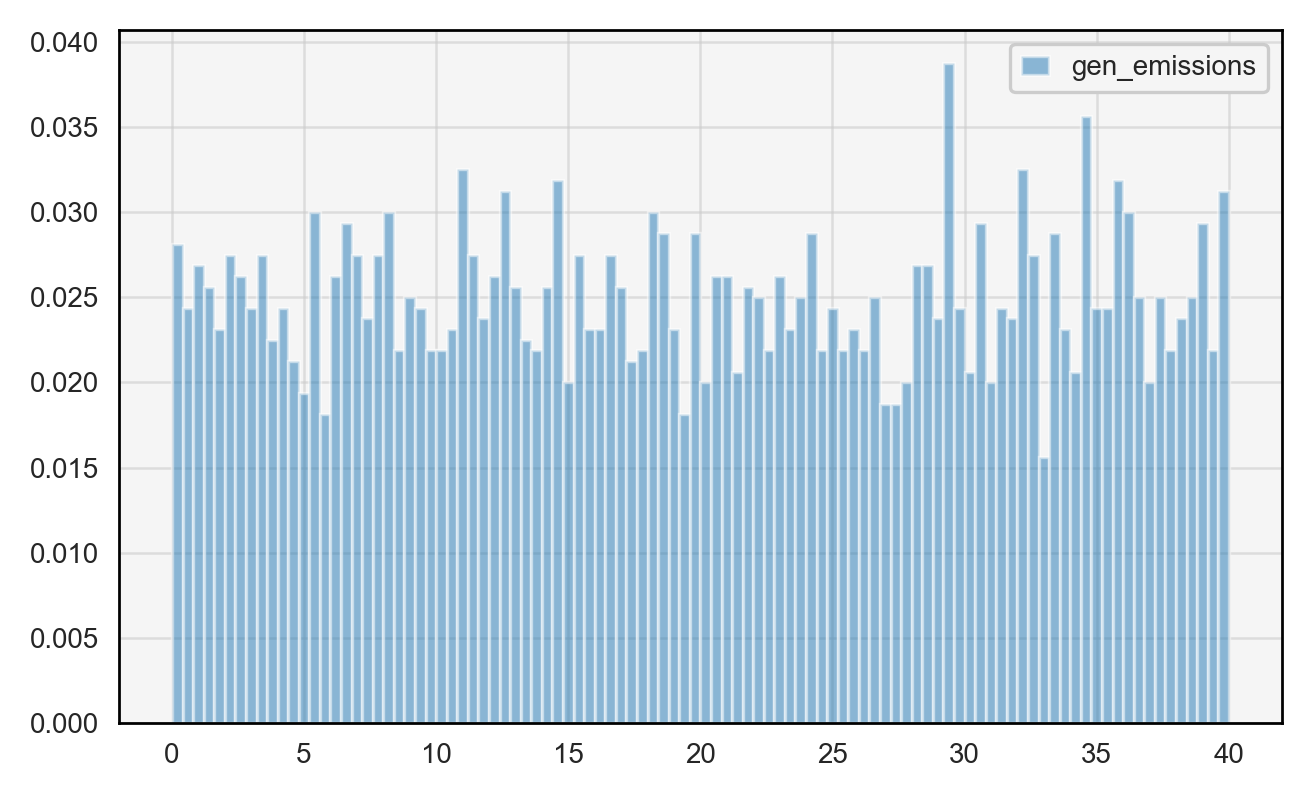

In [40]:
plt.figure(figsize=(5, 3))
plt.hist(
    np.squeeze(gen_emiss), bins=50 * 2, alpha=0.5, label="gen_emissions", density=True
)
plt.legend()

plt.show()